# Teddy MAG analysis

In [55]:
import pandas as pd
from glob import glob
import plotnine as pn
import os

from qiime2.plugins.deicode.actions import rpca
from biom import Table, load_table
import qiime2 as q2
from qiime2.plugins.qurro.actions import differential_plot
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 

from skbio.stats.distance import permanova
from skbio import DistanceMatrix

from skbio.diversity import beta_diversity
%matplotlib inline

In [4]:
#Import metadata
md = pd.read_table("../metadata/20190703_TEDDY_Cleaned_Metadata_v2.tsv")
host_md = md.groupby('host_subject_id').agg({'t1d':"first"})

Import FOCUS bin identification data

In [21]:
files = glob("/projects/teddy/metawrap/binning/*/maxbin_70_10_bins/focus_ids/*_All_levels.csv")
df_dict = {}

for file in files:
    host_id=file.split('/')[5].split('.')[0]
    df_dict[host_id] = pd.read_csv(file)
    
    
tax_levels=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species','Strain']
tax_levels=["Genus"]
bin_id_results=[]

for host_id,df in df_dict.items():
    mags=df.columns[8:]
    for mag in mags:
        for tax_level in tax_levels:
            tmp_df = df.sort_values(mag, ascending=False)
            #Get top hit
            first_hit=tmp_df[tax_level].values[0]
            #Get sum of all hits to top hit
            top_hit_sum = tmp_df.loc[tmp_df[tax_level]==first_hit,mag].sum()
            #Compile result
            result = [host_id, mag, tax_level, first_hit, top_hit_sum]
            #Save result
            bin_id_results.append(result)

bin_id_df = pd.DataFrame(bin_id_results, columns=["host_id","MAG","taxa_level","taxon","support"])
bin_id_df = bin_id_df.merge(host_md, left_on="host_id", right_index=True)
bin_id_df["Genomic bins"] = [x.replace('.fna','') for x in bin_id_df.MAG]

## Plot top MAGs

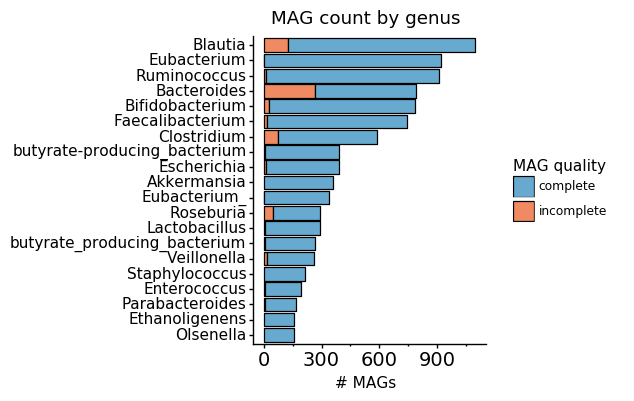

<ggplot: (8740108640790)>

In [9]:
n_taxa=20

plot_df = bin_id_df.copy()
plot_df["identified"] = ["incomplete" if x== "lowQ_bins.fna" else "complete" for x in plot_df.MAG]
tmp = plot_df.taxon.value_counts().to_frame()
#plot_df.columns=["tot"]
#plot_df = plot_df.reset_index()
bacteria_keep = tmp.taxon.index[:n_taxa]
bacteria_keep_list = bacteria_keep.to_list()
bacteria_keep_list.reverse()
plot_df=plot_df.query('taxon in @bacteria_keep')
plot_df["taxon"] = pd.Categorical(plot_df.taxon, categories=bacteria_keep_list)

pn.options.figure_size = (3, 4)

p = (pn.ggplot(data = plot_df) +
    pn.geom_bar( pn.aes( x="taxon", fill="identified"), stat="count", color="black") +
     pn.labs(x='', y="# MAGs", fill="MAG quality", title="MAG count by genus") +
     pn.scale_fill_manual(['#67a9cf','#ef8a62']) +
     pn.coord_flip() +
    pn.theme_classic(base_size=11) +
     pn.theme(axis_text_x = pn.element_text(color="black", size=14),
             axis_text_y = pn.element_text(size=11, color="black"))
    )
p

## Plot top MAGs by T1D

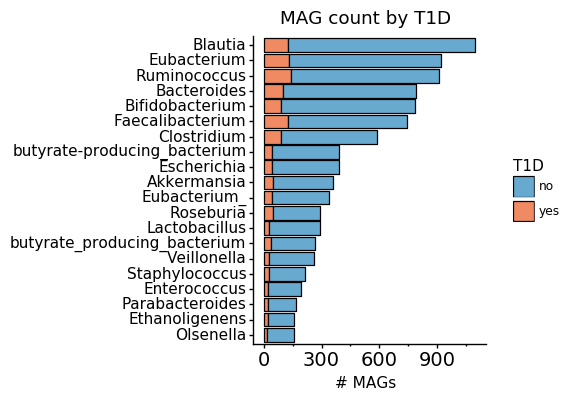

<ggplot: (-9223363296746134861)>

In [12]:
n_taxa=20

plot_df = bin_id_df.copy()
tmp = plot_df.taxon.value_counts().to_frame()
#plot_df.columns=["tot"]
#plot_df = plot_df.reset_index()
bacteria_keep = tmp.taxon.index[:n_taxa]
bacteria_keep_list = bacteria_keep.to_list()
bacteria_keep_list.reverse()
plot_df=plot_df.query('taxon in @bacteria_keep')
plot_df["taxon"] = pd.Categorical(plot_df.taxon, categories=bacteria_keep_list)

pn.options.figure_size = (3, 4)

p = (pn.ggplot(data = plot_df) +
    pn.geom_bar( pn.aes( x="taxon", fill="t1d"), stat="count", color="black") +
     pn.labs(x='', y="# MAGs", fill="T1D", title="MAG count by T1D") +
     pn.scale_fill_manual(['#67a9cf','#ef8a62']) +
     pn.coord_flip() +
    pn.theme_classic(base_size=11) +
     pn.theme(axis_text_x = pn.element_text(color="black", size=14),
             axis_text_y = pn.element_text(size=11, color="black"))
    )
p

## Bin quantitation

In [44]:
quant_files = glob("binning/*/maxbin_quant/bin_abundance_table.tab")

out_list = []
empty_list = []
for file in quant_files:
    host_id=file.split('/')[1]
    try:
        df = pd.read_table(file)
        df = df.merge(bin_id_df.query('host_id == @host_id'), left_on="Genomic bins", right_on="Genomic bins", how="left")
        df = df.rename(columns={host_id:'abundance'})
        out_list.append(df)
    except pd.io.common.EmptyDataError:
        empty_list.append(file)
quant_df = pd.concat(out_list)


In [45]:
quant_df

,Genomic bins,abundance,host_id,MAG,taxa_level,taxon,support,t1d
0,bin.20,38.790203,pt997004,bin.20.fna,Genus,Prevotella,51.254425,no
1,bin.36,13.926208,pt997004,bin.36.fna,Genus,Marinitoga,20.488113,no
2,bin.22,35.283990,pt997004,bin.22.fna,Genus,Lactobacillus,96.206340,no
3,bin.27,24.685976,pt997004,bin.27.fna,Genus,Bifidobacterium,67.977403,no
4,bin.63,4.995748,pt997004,bin.63.fna,Genus,Faecalibacterium,38.693617,no
...,...,...,...,...,...,...,...,...
2,bin.11,104.599399,pt291640,bin.11.fna,Genus,Clostridium,70.319137,no
3,bin.15,51.236547,pt291640,bin.15.fna,Genus,Lactobacillus,96.304607,no
4,lowQ_bins,37.048675,pt291640,lowQ_bins.fna,Genus,butyrate_producing_bacterium,7.653367,no
5,bin.19,22.704320,pt291640,bin.19.fna,Genus,Klebsiella,69.372112,no


In [48]:
quant_table = quant_df.pivot_table(index="host_id", columns="taxon", values="abundance").fillna(0)

In [49]:
quant_table

taxon,Acholeplasma,Acidaminococcus,Adlercreutzia,Aerococcus,Akkermansia,Alistipes,Ammonifex,Amphibacillus,Anaerococcus,Arcanobacterium,...,Streptococcus,Tannerella,Thermanaerovibrio,Treponema,Unknown Genus,Veillonella,Vibrio,butyrate-producing_bacterium,butyrate_producing_bacterium,candidate_division_SR1_bacterium
host_id,,,,,,,,,,,,,,,,,,,,,
pt285042,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
pt286091,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,11.627963,0.000000,0.0,0.0,151.534417,0.0,69.720478,0.000000,0.0
pt287709,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,33.501996,0.000000,0.000000,0.0,0.0,0.000000,0.0,17.562889,0.000000,0.0
pt291640,0.0,0.0,0.0,0.0,353.388180,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,37.048675,0.0
pt301254,0.0,0.0,0.0,0.0,162.216822,26.088197,0.0,0.0,0.0,0.0,...,141.222650,0.000000,34.269194,0.0,0.0,143.235891,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pt991425,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,29.753732,0.0,0.000000,0.000000,0.0
pt992845,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
pt995006,0.0,0.0,0.0,0.0,0.000000,32.337166,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,4.877407,0.000000,0.0


In [91]:
#Import to biom and qiime2
bt = Table(data=quant_table.transpose().to_numpy(), observation_ids=list(quant_table.columns), sample_ids=list(quant_table.index), type="OTU table")

#filter to min 500 per sample
min_reads=500
bt.filter(bt.ids()[bt.sum("sample")> min_reads])
qza = q2.Artifact.import_data('FeatureTable[Frequency]', bt)


#Import metadata to qiime2
host_md.index.name="featureid"
q2_md = q2.Metadata(host_md)

Calculate distance matrices and run PERMANOVA for T1D

In [92]:
#Deicode distance
deicode_bplt_qza, deicode_dm_qza = rpca(qza, min_sample_count=500, min_feature_count=2)
deicode_dm = deicode_dm_qza.view(DistanceMatrix)
#Brat-curtis distance
bc_dist = beta_diversity(metric="braycurtis", counts=quant_table.values, ids=quant_table.index)
#Jaccard distance
jaccard_dist = beta_diversity(metric="jaccard", counts=quant_table.values, ids=quant_table.index)

#Calculate PERMANOVAS
bc_perm = permanova(bc_dist, grouping=host_md, column="t1d")
jaccard_perm = permanova(jaccard_dist, grouping=host_md, column="t1d")
deicode_perm = permanova(deicode_dm, grouping=host_md, column="t1d")

perm_df = pd.DataFrame([deicode_perm,jaccard_perm,bc_perm], index=["Deicode","Jaccard","Bray-Curtis"])
perm_df

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations
Deicode,PERMANOVA,pseudo-F,382,2,1.020276,0.372,999
Jaccard,PERMANOVA,pseudo-F,512,2,1.773333,0.030,999
Bray-Curtis,PERMANOVA,pseudo-F,512,2,1.821052,0.031,999


___

### Songbird differential abundance

In [57]:
from zipfile import ZipFile
def get_q2(file):
    """Given path to modela_fit.qzv, returns q2 score"""
    with ZipFile(file, 'r') as z:
        index_file=[x for x in z.namelist() if "index.html" in x][0]
        with z.open(index_file) as f:
            q2=f.readlines()[3].split()[-1].decode("utf-8") .replace("</p>",'')
            return(q2)

100%|██████████| 75000/75000 [00:32<00:00, 2286.24it/s]


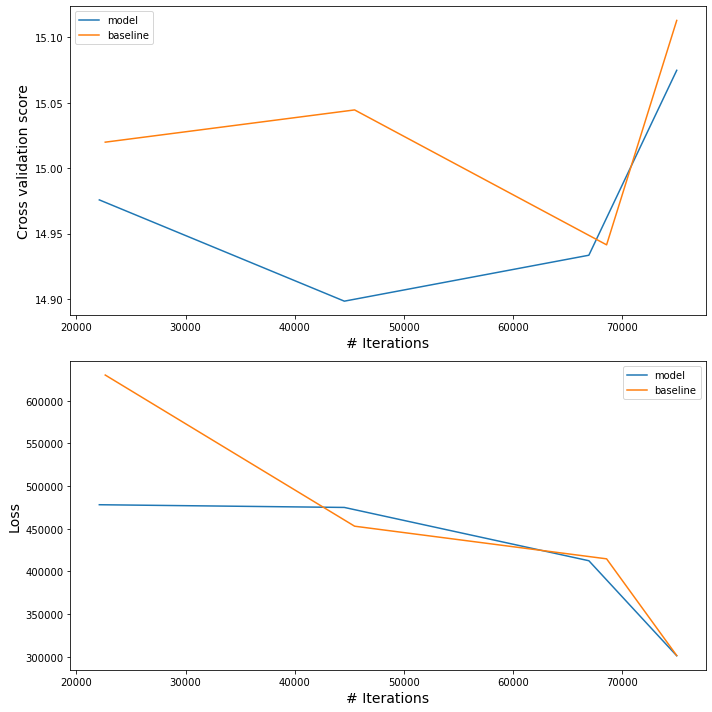

In [93]:
#Run/Import Songbird
folder="bin_quant_songbird"
!mkdir -p $folder

formula = "t1d"
songbird_dict = {}

#Run Songbird
(temp_differentials,
 temp_regression_stats,
 temp_regression_biplot) = multinomial(table=qza,
                                       metadata=q2_md,
                                       formula=formula,
                                      min_sample_count=0,
                                      min_feature_count=0)
#Run null model (just sex)
(null_differentials,
 null_regression_stats,
 null_regression_biplot) = multinomial(table=qza,
                                       metadata=q2_md,
                                       formula="1",
                                      min_sample_count=0,
                                      min_feature_count=0)
#Run qurro
#tmp_qurro = differential_plot(ranks= temp_differentials,
#                                table= qza,
#                                sample_metadata=q2_md).visualization
#Evaluate model fit
tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                baseline_stats = null_regression_stats).visualization



#Add outputs to master dictionary
songbird_dict["differentials"] = temp_differentials
songbird_dict["regression_stats"] = temp_regression_stats
songbird_dict["regression_biplot"] = temp_regression_biplot
#songbird_dict["qurro"] = tmp_qurro
songbird_dict["model_fit"] = tmp_model_fit
#Save outputs
temp_differentials.save("{}/met_differentials.qza".format(folder))
temp_regression_stats.save("{}/met_regression_stats.qza".format(folder))
temp_regression_biplot.save("{}/met_regression_biplot.qza".format(folder))
#tmp_qurro.save("{}/met_qurro.qzv".format(folder))
tmp_model_fit.save("{}/met_model_fit.qzv".format(folder))

#Save q2 value
q2_value = get_q2("{}/met_model_fit.qzv".format(folder))
                                                    

In [94]:
q2_value

'0.002754'

In [96]:
#EC
diff_df = temp_differentials.view(pd.DataFrame)
diff_df.sort_values('t1d[T.yes]').tail(20)

,Intercept,t1d[T.yes]
featureid,,
Alistipes,2.258004,0.574075
Rothia,-1.007214,0.707253
Olsenella,3.678203,0.744587
Ammonifex,-2.110982,0.812577
Mobiluncus,0.489064,0.859955
butyrate_producing_bacterium,3.126925,0.924618
Ruminococcus,4.063830,0.998178
Erwinia,-2.336484,1.126312
Odoribacter,-0.311724,1.159114
